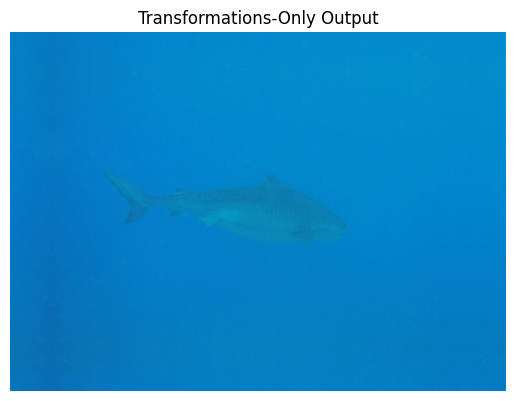

In [1]:
from pathlib import Path
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


INPUT_PATH = Path("/Users/aaronbaggot/Desktop/Image Processing/Image_Processing_Assignment_1/data/raw/Shark 1.PNG")

# Geometric transform controls
ROTATE_DEG  = 0.0       # rotation angle in degrees (+CCW)
SCALE       = 1.0       # uniform scale (e.g., 0.5 halves size, 2.0 doubles)
FLIP_MODE   = None      # options: None, "h", "v", "hv"
PAD_FRAC    = 0.15      # fraction of min(H, W) to pad on all sides
CROP_FRAC   = 1.00      # 0< CROP_FRAC <=1.0, center-crop fraction of the image after padding



PERSPECTIVE_SRC = None  
PERSPECTIVE_DST_SIZE = None 



def apply_flip(I, mode):
    if mode is None:
        return I
    if mode == "h":   # horizontal
        return cv.flip(I, 1)
    if mode == "v":   # vertical
        return cv.flip(I, 0)
    if mode == "hv":  # both (equivalent to 180° rotate without interpolation)
        return cv.flip(I, -1)
    raise ValueError("FLIP_MODE must be one of None, 'h', 'v', 'hv'")

def apply_scale(I, scale):
    if scale == 1.0:
        return I
    H, W = I.shape[:2]
    newW = max(1, int(round(W * scale)))
    newH = max(1, int(round(H * scale)))
    return cv.resize(I, (newW, newH), interpolation=cv.INTER_LINEAR)

def apply_rotate(I, angle_deg):
    if abs(angle_deg) < 1e-6:
        return I
    H, W = I.shape[:2]
    M = cv.getRotationMatrix2D((W/2.0, H/2.0), angle_deg, 1.0)
    # keep same canvas size; use reflect to avoid empty corners
    return cv.warpAffine(I, M, (W, H), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT)

def apply_padding(I, pad_frac):
    if pad_frac <= 0:
        return I
    H, W = I.shape[:2]
    pad = int(round(min(H, W) * pad_frac))
    return cv.copyMakeBorder(I, pad, pad, pad, pad, borderType=cv.BORDER_REFLECT)

def apply_center_crop(I, crop_frac):
    crop_frac = float(crop_frac)
    if crop_frac >= 1.0:
        return I
    if crop_frac <= 0.0:
        raise ValueError("CROP_FRAC must be in (0, 1].")
    H, W = I.shape[:2]
    ch, cw = int(round(H * crop_frac)), int(round(W * crop_frac))
    y0 = (H - ch) // 2
    x0 = (W - cw) // 2
    return I[y0:y0+ch, x0:x0+cw]

def apply_perspective(I, src_pts, dst_size):
    """Optional: purely geometric perspective transform (no detection)."""
    if src_pts is None or dst_size is None:
        return I
    dst_w, dst_h = dst_size
    dst_pts = np.float32([[0, 0], [dst_w-1, 0], [dst_w-1, dst_h-1], [0, dst_h-1]])
    M = cv.getPerspectiveTransform(np.float32(src_pts), dst_pts)
    return cv.warpPerspective(I, M, (dst_w, dst_h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT)

def process_image_transform_only(inp: Path):
    I = cv.imread(str(inp), cv.IMREAD_COLOR)
    if I is None:
        raise FileNotFoundError(inp)

   
    I = apply_flip(I, FLIP_MODE)
    I = apply_scale(I, SCALE)
    I = apply_rotate(I, ROTATE_DEG)
    I = apply_padding(I, PAD_FRAC)
    I = apply_perspective(I, PERSPECTIVE_SRC, PERSPECTIVE_DST_SIZE)
    I = apply_center_crop(I, CROP_FRAC)

    return I

# Run the (transformations-only) pipeline
final_img = process_image_transform_only(INPUT_PATH)
plt.imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Transformations-Only Output")
plt.show()
